In [8]:
text = 'You say goodbye and I say hello.'

In [9]:
text = text.lower() # 모든 문자를 소문자로 변환
text = text.replace('.',' .') # '.'를 ' .'로 변환
text

'you say goodbye and i say hello .'

In [16]:
words = text.split(' ') # 공백을 기준으로 분할
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

### 단어에 ID 부여하고, ID의 리스트로 이용할 수 있도록 하기

In [17]:
word_to_id ={}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [18]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [19]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

### 단어 목록을 단어 ID 목록으로 변경하기

In [20]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

### preprocess() 함수로 구현하기

In [21]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.',' .')
    words = text.split(' ')
    word_to_id ={}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [23]:
corpus, word_to_id, id_to_word = preprocess(text)

### 동시발생 행렬

In [30]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [32]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx. word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i #window사이즈 지정
            right_idx =idx + i
            
            if left_idx >=0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word] += 1
                
    return co_matrix

### 벡터간 유사도
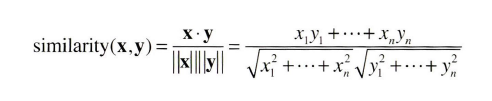https://images.velog.io/images/a01152a/post/0c4bb430-e416-4595-af83-f034bfe06b0e/image.png

In [33]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2) + eps ) #x의 정규화
    ny = y / np.sqrt(np.sum(y**2) + eps) #y의 정규화
    return np.dot(nx, ny)

In [35]:
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1)) # 0.7071067691154799

0.7071067691154799


### 2.3.6 유사 단어의 랭킹 표시

In [38]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # query 검색어를 꺼낸다
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' %query)
        return
    
    print('\n[query]' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' %(id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

In [40]:
most_similar('you', word_to_id, id_to_word, C, top=5)


[query]you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## 2.4 통계 기반 기법 개선하기

## 2.4.1 상호 정보량

In [41]:
def ppmi(C, verbose=False, eps=1e-8):
    #verbose = True 중간 진행상황 출력
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

In [43]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)
print(most_similar('you',word_to_id,id_to_word,W))

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]

[query]you
 goodbye: 0.40786147117614746
 i: 0.40786147117614746
 hello: 0.2763834297657013
 say: 0.0
 and: 0.0
None


## 2.4.3 SVD에 의한 차원 감소

In [44]:
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

In [45]:
print(C[0]) # 동시발생 행렬

[0 1 0 0 0 0 0]


In [46]:
print(W[0]) # PPMI 행렬

[0.    1.807 0.    0.    0.    0.    0.   ]


In [47]:
print(U[0]) # SVD

[-3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01  0.000e+00  9.323e-01
  2.226e-16]


In [48]:
print(U[0, :2])

[-3.409e-01 -1.110e-16]
